In [1]:
# import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess, toml
import matplotlib
import matplotlib.pyplot as plt



import numpy as np
import xarray as xr
import pandas as pd
import sys, glob, os, subprocess

# turn off all warnings (not always necessary)
import warnings
warnings.filterwarnings("ignore")

########################################################################################################################
# define functions for calculating metrics

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    ind = np.array([bind.get(itm, np.nan) for itm in a])
    ind1 = np.where(~np.isnan(ind))[0]
    ind2 = ind[ind1]
    return ind1.astype(int), ind2.astype(int) # None can be replaced by any other "not in b" value

def get_modified_KGE(obs,sim):
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan

    return kge


def get_RMSE(obs,sim):
    rmse = np.sqrt(np.nanmean(np.power((sim - obs),2)))
    return rmse

def get_mean_error(obs, sim):
    bias_err = np.nanmean(sim - obs)
    abs_err = np.nanmean(np.absolute(sim - obs))
    return bias_err, abs_err

def get_max_abs_error(d1, d2):
    return np.nanmax(np.abs(d1-d2))

########################################################################################################################
# define functions for reading CTSM outputs

def main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name):
    ########################################################################################################################
    # read files
    ds_simu = xr.open_mfdataset(CTSMfilelist)
    ds_simu = ds_simu[[clm_q_name]]

    if date_start == 'default' or date_end == 'default':
        print(
            'Either date_start or date_end is default. Evaluation period will be the overlapped period of referene data and simulations')
    else:
        ds_simu = ds_simu.sel(time=slice(date_start, date_end))

    ds_simu = ds_simu.load()

    # change time format
    ds_simu['time'] = ds_simu.indexes['time'].to_datetimeindex()

    ########################################################################################################################
    # get the area of a basin to convert the unit of QRUNOFF from mm/s to m3/s

    with xr.open_dataset(fsurdat) as ds_surdat:
        area = ds_surdat.AREA.values

    # calculate streamflow: although mean is used, for Sean's setting, only one basin should be allowed effective in the calibration
    # streamflow? Use mean for this test
    ds_simu[clm_q_name].values = (ds_simu[clm_q_name].values / 1000) * (area * 1e6)  # raw q: mm/s; raw area km2; target: m3/s

    return ds_simu


########################################################################################################################
# define functions for reading CAMELS data

def read_CAMELS_Q(file_Qobs):
    df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)
    years = df_q_in[1].values
    months = df_q_in[2].values
    days = df_q_in[3].values
    dates = [f'{years[i]}-{months[i]:02}-{days[i]:02}' for i in range(len(years))]
    q_obs = df_q_in[4].values * 0.028316847  # cfs to cms
    q_obs[q_obs < 0] = -9999.0
    df_q_out = pd.DataFrame({'Date': dates, 'Runoff_cms': q_obs})
    return df_q_out

def read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name):
    ########################################################################################################################
    # load observation streamflow
    print('Use streamflow reference file:', ref_streamflow)
    df_q_obs = pd.read_csv(ref_streamflow)
    ds_q_obs = xr.Dataset()
    ds_q_obs.coords['time'] = pd.to_datetime(df_q_obs[ref_q_date].values)
    ds_q_obs[ref_q_name] = xr.DataArray(df_q_obs[ref_q_name].values, dims=['time']) # flexible time
    for i in range(10000):
        coli = ref_q_name + str(i)
        if coli in df_q_obs.columns:
            ds_q_obs[coli] = xr.DataArray(df_q_obs[coli].values, dims=['time'])  # flexible time
        else:
            break
    return ds_q_obs


def add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name):
    ########################################################################################################################
    # add upstream flows to simulated streamflow

    add_flow_file = [f for f in add_flow_file.split(',') if len(f)>0]
    if len(add_flow_file) > 0:
        add_flow_file2 = []
        for f in add_flow_file:
            if not os.path.isfile(f):
                print('File does not exist:', f)
                print('Remove it from add flow file list')
            else:
                add_flow_file2.append(f)
        add_flow_file = add_flow_file2

    if len(add_flow_file) > 0:
        print('Flow files will be added to the incremental downstream basin:', add_flow_file)
        q_dd = np.zeros(len(ds_simu.time))
        num = np.zeros(len(ds_simu.time))
        time0 = ds_simu.time.values
        for i in range(len(add_flow_file)):
            df_addi = read_CAMELS_Q(add_flow_file[i])
            # df_addi = pd.read_csv(add_flow_file[i])
            timei = pd.to_datetime(df_addi[ref_q_date].values)
            ind1, ind2 = ismember(np.array(timei), time0)
            q_dd[ind2] = q_dd[ind2] + df_addi[ref_q_name].values[ind1]
            num[ind2] = num[ind2] + 1
        q_dd[num==0] = np.nan

        ds_simu[clm_q_name].values = ds_simu[clm_q_name].values + q_dd
        ratio = np.sum(~np.isnan(ds_simu[clm_q_name].values)) / len(ds_simu[clm_q_name].values)
        if ratio < 0.5:
            print('Warning!!!')
        print(f'The valid ratio of simulated streamflow is {ratio} after add upstream flow')

    return ds_simu


In [2]:
allbasin = [f'level1_{i}' for i in range(101)]

In [26]:
# MO-ASMO metrics
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_MOASMO'

moasmo_metrics = np.nan * np.zeros([len(allbasin), 4])

for i in range(len(allbasin)):
    basin = allbasin[i]
    df = []
    for j in range(9):
        filei = f'{inpath}/{basin}_MOASMOcalib/ctsm_outputs/iter{j}_all_metric.csv'
        if not os.path.isfile(filei):
            continue
        dfi = pd.read_csv(filei)
        dfi['iter'] = j
        dfi['trial'] = np.arange(len(dfi))
        df.append(dfi)
    
    if len(df)>0:
        df = pd.concat(df)
        # df['metric1'] = 1 - df['metric1'] # to KGE
        # Assuming df is your DataFrame with the two metrics
        df['Rank_Metric1'] = df['metric1'].rank(ascending=True)
        df['Rank_Metric2'] = df['metric2'].rank(ascending=True)
        df['Total_Rank'] = df['Rank_Metric1'] + df['Rank_Metric2']
        
        index = np.argmin(df['Total_Rank'].values)
        
        moasmo_metrics[i, 0] = 1 - df.iloc[index]['metric1'] # KGE
        moasmo_metrics[i, 1] = df.iloc[index]['metric2'] # monthly bias
        moasmo_metrics[i, 2] = df.iloc[index]['iter'] # KGE
        moasmo_metrics[i, 3] = df.iloc[index]['trial'] # monthly bias

In [4]:
# read Ostrich metrics
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich'
infilelist_ostmodel = [f'{inpath}/{i}_Ostrich/archive/PreserveBestModel/OstModel0.txt' for i in allbasin]
num = len(infilelist_ostmodel)
kge_ost = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_OstModel = infilelist_ostmodel[i]
    df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
    df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
    kge_ost[i, 0] = -df_OstModel['obj.function'].values[0]
    kge_ost[i, 1] = -df_OstModel['obj.function'].values[-1]

In [5]:
# use MO_ASMO metrics to evaluate Ostrich netcdf simulations

train_startdate = []
inpath = '/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_Ostrich/configuration'
for b in allbasin:
	b = b.replace('_', '-')
	file = f'{inpath}/_{b}_config_Ostrich.toml'
	config = toml.load(file)
	train_startdate.append(config['RUN_STARTDATE'])


ostrich_metrics = np.nan * np.zeros([len(allbasin), 2])
for b in range(len(allbasin)):
    
    basin = allbasin[b]
    
    ######## required input arguments
    pathCTSM = f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}'
    path_archive = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/archive/PreserveBestModel/'

    year = int(train_startdate[i][:4])
    date_start = f'{year+1}-10-01'
    date_end = f'{year+6}-10-01'

    # reference files (streamflow, snow cover). if a file cannot be found, it won't be inclulded in the calibration
    ref_streamflow = f'/glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/{basin}_Ostrich/refdata/streamflow_data.csv'

    # add_flow_file. sometimes upstream flow needs to be added to the incremental downstream area runoff
    add_flow_file = ''


    ######## default variable names
    clm_q_name = 'QRUNOFF' # default runoff variable name
    clm_q_sdim = 'lndgrid' # spatial dim name
    ref_q_name = 'Runoff_cms'
    ref_q_date = 'Date'

    ########################################################################################################################
    # load CTSM streamflow (m3/s)
    CTSMfilelist = glob.glob(f'{path_archive}/*.h1.*.nc')
    CTSMfilelist.sort()
    
    file = f'{pathCTSM}/Buildconf/clmconf/lnd_in'
    fsurdat = ''
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('fsurdat'):
                fsurdat = line.split('=')[-1].strip()
                fsurdat = fsurdat.replace('\'', '')
    
    ds_simu = main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name)
    ds_simu = ds_simu.mean(dim=clm_q_sdim, skipna=True)

    ########################################################################################################################
    # load CAMELS observation streamflow (m3/s)
    ds_q_obs = read_CAMELS_Q_and_to_xarray(ref_streamflow, ref_q_date, ref_q_name)

    ########################################################################################################################
    # add upstream flows to simulated streamflow
    ds_simu = add_upstream_flow(add_flow_file, ds_simu, ref_q_date, ref_q_name, clm_q_name)

    ########################################################################################################################
    # evaluation

    ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
    ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))

    d1 = ds_q_obs[ref_q_name].values
    d2 = ds_simu[clm_q_name].values
    d1[d1<0] = np.nan
    d2[d2<0] = np.nan
    ds_q_obs[ref_q_name].values = d1
    ds_simu[clm_q_name].values = d2

    kge_q = get_modified_KGE(obs=d1, sim=d2)

    d1 = ds_q_obs[ref_q_name].groupby('time.month').mean().values
    d2 = ds_simu[clm_q_name].groupby('time.month').mean().values
    maxabserror_q = get_max_abs_error(d1, d2)
    
    ostrich_metrics[b, :] = [kge_q, maxabserror_q]

Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_0_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_1_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_2_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_3_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_4_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/campaign/cgd/tss/people/guoqiang/CTSMcases/CAMELS_Calib/Calib_all_HH_Ostrich/level1_5_Ostrich/refdata/streamflow_data.csv
Use streamflow reference file: /glade/ca

# Compare MO-ASMO and Ostrich DDS

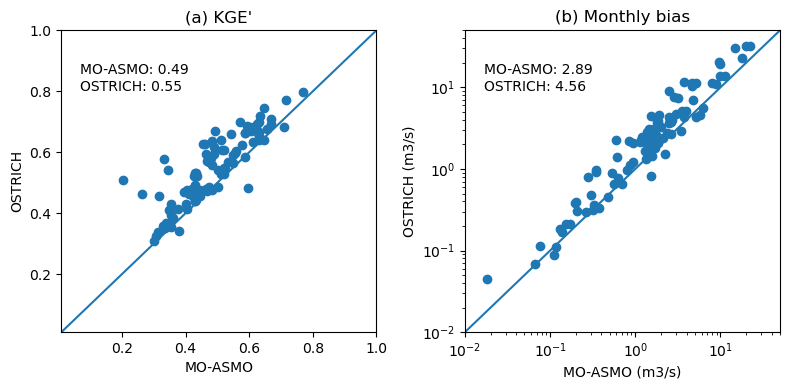

In [71]:
fig, axs = plt.subplots(1, 2, figsize=[8, 4])

titles = ["(a) KGE'", "(b) Monthly bias"]
lims = [1, 50]
units = ['', ' (m3/s)']

for i in range(2):
    ax = axs[i]
    d1 = moasmo_metrics[:, i]
    d2 = ostrich_metrics[:, i]
    ax.scatter(d1, d2)
    ax.plot([0, lims[i]], [0, lims[i]])
    ax.set_xlabel(f'MO-ASMO{units[i]}')
    ax.set_ylabel(f'OSTRICH{units[i]}')
    ax.set_title(titles[i])
    ax.set_xlim([0.01, lims[i]])
    ax.set_ylim([0.01, lims[i]])
    
    if i==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
    
    ind = ~np.isnan(d1+d2)
    d1m, d2m = np.nanmean(d1[ind]), np.nanmean(d2[ind])
    t = f'MO-ASMO: {d1m:.2f}\nOSTRICH: {d2m:.2f}'
    ax.text(0.06, 0.8, t, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('MOASMO_vs_Ostrich.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()